# Performance comparison

This notebook compares the performance of `cuDF` and `pandas`. The comparisons performed are on identical data sizes. This notebook primarily showcases the factor
of speedups users can have when the similar `pandas` APIs are run on GPUs using `cudf`.

The hardware details used to run these performance comparisons are at the end of this page.

**Note**: This notebook is written to measure performance on NVIDIA GPUs with large memory. If running on hardware with lower memory, please consider lowering the `num_rows` values. Performance results may vary by data size, as well as the CPU and GPU used.

In [1]:
import os
import time
import timeit
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cudf
print(f"{cudf.__version__=}")

cudf.__version__='24.02.02'


In [2]:
np.random.seed(0)

## Concat, count & joins performance

In [3]:
timeit_number = 10
num_rows = 3_000_000
sub_sample = int(num_rows / 3)

In [4]:
pdf = pd.DataFrame(
    {
        "numbers": np.random.randint(-1000, 1000, num_rows, dtype="int64"),
        "business": np.random.choice(
            ["McD", "Buckees", "Walmart", "Costco"], size=num_rows
        ),
    }
)
pdf

,numbers,business
0,-316,Walmart
1,-441,Walmart
2,653,Buckees
3,216,McD
4,-165,McD
...,...,...
2999995,-653,Costco
2999996,-839,Costco
2999997,-888,McD
2999998,-253,Costco


In [5]:
gdf = cudf.from_pandas(pdf)
gdf

,numbers,business
0,-316,Walmart
1,-441,Walmart
2,653,Buckees
3,216,McD
4,-165,McD
...,...,...
2999995,-653,Costco
2999996,-839,Costco
2999997,-888,McD
2999998,-253,Costco


In [6]:
def timeit_pandas_cudf(pd_obj, gd_obj, func, **kwargs):
    """
    A utility function to measure execution time of an
    API(`func`) in pandas & cudf.

    Parameters
    ----------
    pd_obj : Pandas object
    gd_obj : cuDF object
    func : callable
    """
    pandas_time = timeit.timeit(lambda: func(pd_obj), **kwargs)
    cudf_time = timeit.timeit(lambda: func(gd_obj), **kwargs)
    return pandas_time, cudf_time

In [7]:
pandas_value_counts, cudf_value_counts = timeit_pandas_cudf(
    pdf, gdf, lambda df: df.value_counts(), number=timeit_number
)

In [8]:
pdf = pdf.head(sub_sample)
gdf = gdf.head(sub_sample)

In [9]:
pandas_concat = timeit.timeit(lambda: pd.concat([pdf, pdf, pdf]), number=timeit_number)

In [10]:
cudf_concat = timeit.timeit(lambda: cudf.concat([gdf, gdf, gdf]), number=timeit_number)

In [11]:
pandas_groupby, cudf_groupby = timeit_pandas_cudf(
    pdf,
    gdf,
    lambda df: df.groupby("business").agg(["min", "max", "mean"]),
    number=timeit_number,
)

In [12]:
pdf = pd.DataFrame(
    {
        "numbers": np.random.randint(-1000, 1000, sub_sample, dtype="int64"),
        "business": np.random.choice(
            ["McD", "Buckees", "Walmart", "Costco"], size=sub_sample
        ),
    }
)
gdf = cudf.from_pandas(pdf)

In [13]:
pandas_merge, cudf_merge = timeit_pandas_cudf(
    pdf, gdf, lambda df: df.merge(df), number=timeit_number
)

In [14]:
performance_df = pd.DataFrame(
    {
        "cudf speedup vs. pandas": [
            pandas_value_counts / cudf_value_counts,
            pandas_concat / cudf_concat,
            pandas_groupby / cudf_groupby,
            pandas_merge / cudf_merge,
        ],
    },
    index=["value_counts", "concat", "groupby", "merge"],
)
performance_df

,cudf speedup vs. pandas
value_counts,18.183413
concat,8.509434
groupby,21.215641
merge,19.526079


In [15]:
def performance_plot(df, xlabel=None):
    # ylim is 20% above max value
    ylim_max = df["cudf speedup vs. pandas"].max() + (df["cudf speedup vs. pandas"].max() / 20)
    ax = df.plot.bar(
        color="#7400ff",
        ylim=(1, ylim_max),
        rot=0,
        xlabel=xlabel,
        ylabel="Speedup factor",
    )
    ax.bar_label(ax.containers[0], fmt="%.0f")
    plt.show()

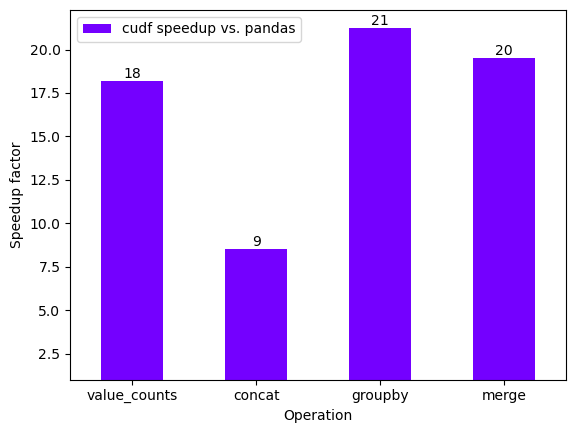

In [16]:
performance_plot(performance_df, xlabel="Operation")

In [17]:
# Cleaning up used memory for later benchmarks
del pdf
del gdf
import gc

_ = gc.collect()

## Strings Performance

In [18]:
timeit_number = 10
num_rows = 3_000_000

In [19]:
pd_series = pd.Series(
    np.random.choice(
        ["123", "56.234", "Walmart", "Costco", "rapids ai"], size=num_rows
    )
)

In [20]:
gd_series = cudf.from_pandas(pd_series)

In [21]:
pandas_upper, cudf_upper = timeit_pandas_cudf(
    pd_series, gd_series, lambda s: s.str.upper(), number=timeit_number
)

In [22]:
pandas_contains, cudf_contains = timeit_pandas_cudf(
    pd_series, gd_series, lambda s: s.str.contains(r"[0-9][a-z]"), number=timeit_number
)

In [23]:
pandas_isalpha, cudf_isalpha = timeit_pandas_cudf(
    pd_series, gd_series, lambda s: s.str.isalpha(), number=timeit_number
)

In [24]:
performance_df = pd.DataFrame(
    {
        "cudf speedup vs. pandas": [
            pandas_upper / cudf_upper,
            pandas_contains / cudf_contains,
            pandas_isalpha / cudf_isalpha,
        ],
    },
    index=["upper", "contains", "isalpha"],
)
performance_df

,cudf speedup vs. pandas
upper,351.793418
contains,166.784571
isalpha,1067.736994


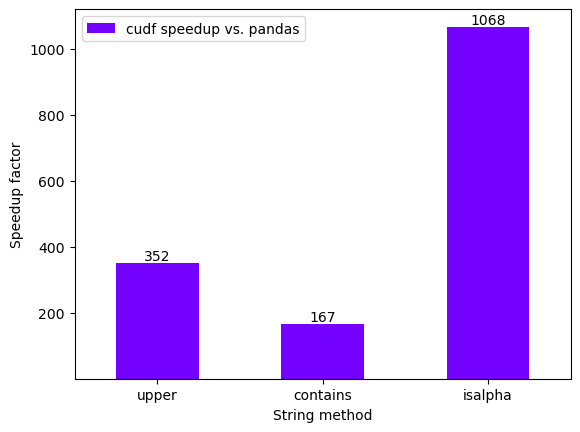

In [25]:
performance_plot(performance_df, xlabel="String method")

## User-defined function (UDF) performance (with JIT overhead)

The first UDF runs include JIT compilation overhead, due to which the performance of first run and average of next few runs are compared separately.

In [26]:
num_rows = 100_000

In [27]:
pdf_age = pd.DataFrame(
    {
        "age": np.random.randint(0, 100, num_rows),
    }
)
pdf_age

,age
0,88
1,67
2,3
3,64
4,86
...,...
99995,7
99996,71
99997,1
99998,71


In [28]:
gdf_age = cudf.from_pandas(pdf_age)
gdf_age

,age
0,88
1,67
2,3
3,64
4,86
...,...
99995,7
99996,71
99997,1
99998,71


In [29]:
def age_udf(row):
    if row["age"] < 18:
        return 0
    elif 18 <= row["age"] < 20:
        return 1
    elif 20 <= row["age"] < 30:
        return 2
    elif 30 <= row["age"] < 40:
        return 3
    elif 40 <= row["age"] < 50:
        return 4
    elif 50 <= row["age"] < 60:
        return 5
    elif 60 <= row["age"] < 70:
        return 6
    else:
        return 7

In [30]:
pandas_int_udf, cudf_int_udf = timeit_pandas_cudf(
    pdf_age, gdf_age, lambda df: df.apply(age_udf, axis=1), number=1
)

In [31]:
def str_isupper_udf(row):
    if row.isupper():
        return 0
    else:
        return 1

In [32]:
pd_series = pd.Series(
    np.random.choice(["ABC", "abc", "hello world", "AI"], size=num_rows),
    name="strings",
)
pd_series

0                abc
1                ABC
2                abc
3        hello world
4                ABC
            ...     
99995             AI
99996             AI
99997            ABC
99998            abc
99999            abc
Name: strings, Length: 100000, dtype: object

In [33]:
gd_series = cudf.from_pandas(pd_series)
gd_series

0                abc
1                ABC
2                abc
3        hello world
4                ABC
            ...     
99995             AI
99996             AI
99997            ABC
99998            abc
99999            abc
Name: strings, Length: 100000, dtype: object

In [34]:
pandas_str_udf, cudf_str_udf = timeit_pandas_cudf(
    pd_series, gd_series, lambda s: s.apply(str_isupper_udf), number=1
)

In [35]:
performance_df = pd.DataFrame(
    {
        "cudf speedup vs. pandas": [
            pandas_int_udf / cudf_int_udf,
            pandas_str_udf / cudf_str_udf,
        ]
    },
    index=["Numeric", "String"],
)
performance_df

,cudf speedup vs. pandas
Numeric,3.537433
String,0.241763


Below is the plot showing performance speedup in case of Numeric UDFs & String UDFs on their first runs.

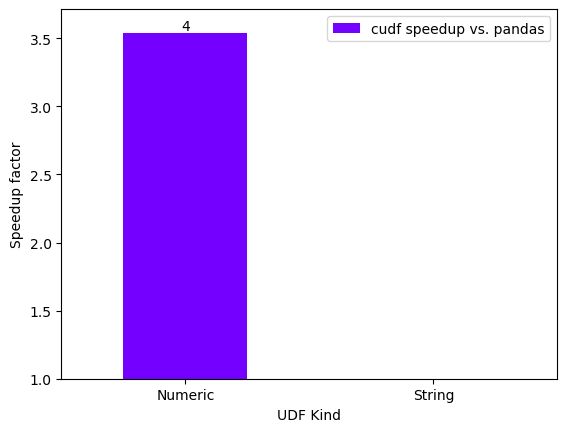

In [36]:
performance_plot(performance_df, xlabel="UDF Kind")

## User-defined function (UDF) performance (without JIT overhead)

In [37]:
timeit_number = 10

In [38]:
pandas_int_udf, cudf_int_udf = timeit_pandas_cudf(
    pdf_age, gdf_age, lambda df: df.apply(age_udf, axis=1), number=timeit_number
)

In [39]:
pandas_str_udf, cudf_str_udf = timeit_pandas_cudf(
    pd_series, gd_series, lambda s: s.apply(str_isupper_udf), number=timeit_number
)

In [40]:
performance_df = pd.DataFrame(
    {
        "cudf speedup vs. pandas": [
            pandas_int_udf / cudf_int_udf,
            pandas_str_udf / cudf_str_udf,
        ]
    },
    index=["Numeric", "String"],
)
performance_df

,cudf speedup vs. pandas
Numeric,1443.073868
String,31.230242


Below is the plot showing performance speedup in case of Numeric UDFs & String UDFs on their consequent runs. In this case the speedup is massive because of no JIT overhead present.

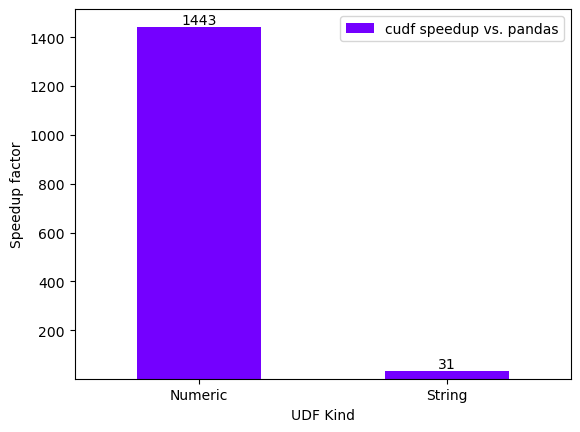

In [41]:
performance_plot(performance_df, xlabel="UDF Kind")

## UDF Performance in GroupBy

In [42]:
num_rows = 1_000_000
timeit_number = 10

In [43]:
pdf = pd.DataFrame()
pdf["key"] = np.random.randint(0, 2, num_rows)
pdf["val"] = np.random.randint(0, 7, num_rows)


def custom_formula_udf(df):
    df["out"] = df["key"] * df["val"] - 10
    return df


gdf = cudf.from_pandas(pdf)

In [44]:
pandas_udf_groupby, cudf_udf_groupby = timeit_pandas_cudf(
    pdf,
    gdf,
    lambda df: df.groupby(["key"], group_keys=False).apply(custom_formula_udf),
    number=timeit_number,
)

In [45]:
performance_df = pd.DataFrame(
    {"cudf speedup vs. pandas": [pandas_udf_groupby / cudf_udf_groupby]},
    index=["Grouped UDF"],
)
performance_df

,cudf speedup vs. pandas
Grouped UDF,4.658045


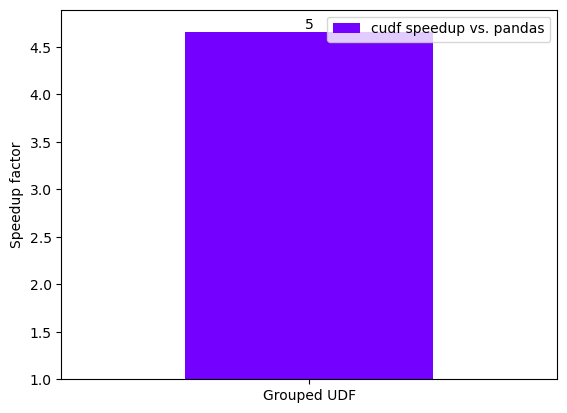

In [46]:
performance_plot(performance_df)

# System Configuration

## CPU Configuration

In [47]:
!lscpu

Architecture:                       x86_64
CPU op-mode(s):                     32-bit, 64-bit
Byte Order:                         Little Endian
Address sizes:                      48 bits physical, 48 bits virtual
CPU(s):                             4
On-line CPU(s) list:                0-3
Thread(s) per core:                 2
Core(s) per socket:                 2
Socket(s):                          1
NUMA node(s):                       1
Vendor ID:                          AuthenticAMD
CPU family:                         23
Model:                              49
Model name:                         AMD EPYC 7R32
Stepping:                           0
CPU MHz:                            2799.918
BogoMIPS:                           5599.83
Hypervisor vendor:                  KVM
Virtualization type:                full
L1d cache:                          64 KiB
L1i cache:                          64 KiB
L2 cache:                           1 MiB
L3 cache:                           8 MiB
N

## GPU Configuration

In [48]:
!nvidia-smi

Mon Mar  4 00:09:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A10G                    On  | 00000000:00:1E.0 Off |                    0 |
|  0%   28C    P0              61W / 300W |    348MiB / 23028MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--